In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

from sklearn.preprocessing import Imputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel, RFE
from sklearn.preprocessing import MinMaxScaler, StandardScaler,scale
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import VarianceThreshold
import seaborn as sns
from sklearn.model_selection import train_test_split

import torch
import torchvision.transforms as transforms
from torch.autograd import Variable
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch import nn, optim
import torch.nn.init as init
import torch.utils.data as Data
import math


import matplotlib.pyplot as plt
import torch.multiprocessing as mp


In [2]:
mp.set_start_method('spawn')

## hyperparameters

In [3]:
batch_size = 128
use_gpu = True
y_scale = True
lr = 0.0015
weight_decay = 0.01

# Batch size and learning rate is hyperparameters in deep learning
# suggest batch_size is reduced, lr is also reduced which will reduce concussion

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [5]:
X = pd.read_csv('./dataset-0510/train.csv')
X_test = pd.read_csv('./dataset-0510/test.csv')


columns = X.columns


In [6]:
columns

Index(['building_id', 'building_material', 'city', 'txn_dt', 'total_floor',
       'building_type', 'building_use', 'building_complete_dt', 'parking_way',
       'parking_area',
       ...
       'XIV_500', 'XIV_index_500', 'XIV_1000', 'XIV_index_1000', 'XIV_5000',
       'XIV_index_5000', 'XIV_10000', 'XIV_index_10000', 'XIV_MIN',
       'total_price'],
      dtype='object', length=235)

## Imputer, Scaler, Feature selection

In [7]:
# step1. Imputation transformer for completing missing values.
step1 = ('Imputer', Imputer())
# step2. MinMaxScaler
step2 = ('MinMaxScaler', MinMaxScaler())
# step3. feature selection
#step3 = ('FeatureSelection', SelectFromModel(RandomForestRegressor()))
step3 = ('FeatureSelection', VarianceThreshold())

pipeline = Pipeline(steps=[step1, step2, step3])


/home/islab/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [8]:
y = X['total_price']
X = X.drop(columns=['building_id', 'total_price'], axis=1)
X_test = X_test.drop(columns=['building_id'], axis=1)


### X sacle

In [9]:
X = pipeline.fit_transform(X)
print(X.shape)

X_test = pipeline.transform(X_test)
print(X_test.shape)

(60000, 211)
(10000, 211)


In [10]:
#X = pd.DataFrame(X, columns=columns)

### y scale 

In [11]:
y_scaler = MinMaxScaler()
if y_scale:
    y = y_scaler.fit_transform(y.values.reshape(-1, 1))



In [12]:
X_train, X_eval, y_train, y_eval = train_test_split(X, y, test_size=0.3, random_state=42) 

In [13]:
X_train = torch.from_numpy(X_train).float().to(device)
X_eval = torch.from_numpy(X_eval).float().to(device)

y_train = torch.from_numpy(y_train).float().to(device)
y_eval = torch.from_numpy(y_eval).float().to(device)

X_test = torch.from_numpy(X_test).float().to(device)

In [14]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)

torch.Size([42000, 211])
torch.Size([10000, 211])
torch.Size([42000, 1])


In [15]:
train_dataset = Data.TensorDataset(X_train, y_train)
train_loader = Data.DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0,
)

eval_dataset = Data.TensorDataset(X_eval, y_eval)
eval_loader = Data.DataLoader(
    dataset=eval_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0,
)

## building model

In [16]:


class DNN(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.fc1 = nn.Linear(211, 256)
        self.bn1 = nn.BatchNorm1d(num_features=256)
        
        self.fc2 = nn.Linear(256, 512)
        self.bn2 = nn.BatchNorm1d(num_features=512)
        
        self.fc3 = nn.Linear(512, 512)
        self.bn3 = nn.BatchNorm1d(num_features=512)
        
        self.fc4 = nn.Linear(512, 256)
        self.bn4 = nn.BatchNorm1d(num_features=256)
        
        self.fc5 = nn.Linear(256, 128)
        self.bn5 = nn.BatchNorm1d(num_features=128)
        
        self.fc6 = nn.Linear(128, 64)
        self.bn6 = nn.BatchNorm1d(num_features=64)
        
        self.fc7 = nn.Linear(64, 32)
        self.bn7 = nn.BatchNorm1d(num_features=32)
        
        self.fc8 = nn.Linear(32, 1)
        
        self.dropout = nn.Dropout(p=0.5)
        
    def forward(self, x):
        #x = x.unsqueeze(0)
        
        x = F.relu(self.bn1(self.fc1(x)))
        x = F.relu(self.bn2(self.fc2(x)))
        x = F.relu(self.bn3(self.fc3(x)))
        x = F.relu(self.bn4(self.fc4(x)))
        x = F.relu(self.bn5(self.fc5(x)))
        x = F.relu(self.bn6(self.fc6(x)))
        x = F.relu(self.bn7(self.fc7(x)))
        x = self.fc8(x)
        return x

In [17]:
model = DNN().to(device)
#model.apply(weights_init_uniform)
criterion = nn.MSELoss()
optim = optim.Adam(model.parameters(), lr= lr)

In [18]:

def train_func(model, loader):
    model.train()
    train_loss = []
    for step, (batch_x, batch_y) in enumerate(loader):
        optim.zero_grad()
        pred = model(batch_x)
        loss = torch.sqrt(criterion(pred, batch_y))
        loss.backward()
        optim.step()

        train_loss.append(loss.item())
        
    print('training loss', np.array(train_loss).mean())
    return np.array(train_loss).mean()




def eval_func(model, loader):
    model.eval()
    eval_loss = []
    with torch.no_grad():
        for step, (batch_x, batch_y) in enumerate(loader):
            pred = model(batch_x)
            loss = torch.sqrt(criterion(pred, batch_y))
            
            eval_loss.append(loss.item())
        print('testing loss', np.array(eval_loss).mean())
    return np.array(eval_loss).mean()

def test_func(model, X):
    model.eval()
    with torch.no_grad():
        pred = model(X)
        
        pred = pred.cpu().numpy()
        if y_scale:
            pred = y_scaler.inverse_transform(pred)            
    return pred


def accuracy(model, pct_close=0.5):
    #pred, y_eval
    model.eval()
    with torch.no_grad():
        pred = model(X_eval)
        
    n_correct = torch.sum((torch.abs(pred - y_eval) < torch.abs(pct_close * y_eval)))
    result = (n_correct.item()/len(y_eval))  # scalar
    return result 

def plot(label, pred):
    plt.plot(label, label='actual')
    plt.plot(pred, label='pred')
    plt.legend(frameon=False)
    

In [19]:
train_losses = []
eval_losses = []
accs = []
for t in range(20000):
    print('epochs', t)
    train_loss = train_func(model, train_loader)
    if (t+1) % 10 == 0:
        eval_loss = eval_func(model, eval_loader)
        #acc = accuracy(model)
        
        eval_losses.append(eval_loss)
        train_losses.append(train_loss)
        
        #accs.append(acc)
        #print('accuracy: ',acc)

epochs 0
training loss 0.014515719572535085
epochs 1
training loss 0.00841136086282057
epochs 2
training loss 0.007530145933441138
epochs 3
training loss 0.006992553416667874
epochs 4
training loss 0.006633128201954158
epochs 5
training loss 0.0064412385202649875
epochs 6
training loss 0.006191230652214093
epochs 7
training loss 0.006318722247913208
epochs 8
training loss 0.005748986342630284
epochs 9
training loss 0.006305797171345869
testing loss 0.007032227410162066
epochs 10
training loss 0.005810686852782965
epochs 11
training loss 0.0059332249025845375
epochs 12
training loss 0.005696046311906496
epochs 13
training loss 0.0058348021589610215
epochs 14
training loss 0.005494942227633257
epochs 15
training loss 0.005311051099476232
epochs 16
training loss 0.005181955861134347
epochs 17
training loss 0.005217187635255213
epochs 18
training loss 0.005188056800336121
epochs 19
training loss 0.005139814758047711
testing loss 0.009117089340740696
epochs 20
training loss 0.00521787322207

training loss 0.001882448174642529
epochs 168
training loss 0.0021969045262562967
epochs 169
training loss 0.0018200958927875345
testing loss 0.00386408093576947
epochs 170
training loss 0.0017676213455434582
epochs 171
training loss 0.0017626638125096048
epochs 172
training loss 0.0016765111583528479
epochs 173
training loss 0.0017520530373325125
epochs 174
training loss 0.0017203407416595741
epochs 175
training loss 0.0016682178130950835
epochs 176
training loss 0.0017166772139354928
epochs 177
training loss 0.001648915203721305
epochs 178
training loss 0.0016647514048185323
epochs 179
training loss 0.001679833066730412
testing loss 0.007361261689282478
epochs 180
training loss 0.0017041611963936826
epochs 181
training loss 0.0017661943079515907
epochs 182
training loss 0.0016093943464445194
epochs 183
training loss 0.0017583242767578201
epochs 184
training loss 0.001751956249846253
epochs 185
training loss 0.0017906673247982553
epochs 186
training loss 0.0016832630998188896
epochs 1

training loss 0.0012460170528854281
epochs 331
training loss 0.001289768810426437
epochs 332
training loss 0.0013266299385223594
epochs 333
training loss 0.0013029853584058016
epochs 334
training loss 0.0013139508719454125
epochs 335
training loss 0.0012304475260289855
epochs 336
training loss 0.0013518570218161653
epochs 337
training loss 0.0017786752697969235
epochs 338
training loss 0.0012961472731400677
epochs 339
training loss 0.001237035886983254
testing loss 0.003153931860174614
epochs 340
training loss 0.001175721059907171
epochs 341
training loss 0.0013015790974104204
epochs 342
training loss 0.0012050649992651717
epochs 343
training loss 0.0011623051848353133
epochs 344
training loss 0.0012255134892516903
epochs 345
training loss 0.0011611528359183696
epochs 346
training loss 0.001231255291077934
epochs 347
training loss 0.0012439439635112384
epochs 348
training loss 0.0012803430825409602
epochs 349
training loss 0.001157122987745709
testing loss 0.0028710908566912017
epochs 

training loss 0.001080225576720226
epochs 495
training loss 0.0010011442811341566
epochs 496
training loss 0.0009688474194572723
epochs 497
training loss 0.0009906610238152105
epochs 498
training loss 0.000980133780789219
epochs 499
training loss 0.0010034850391447488
testing loss 0.0035813890285261558
epochs 500
training loss 0.0010107092206907036
epochs 501
training loss 0.0010460645309295562
epochs 502
training loss 0.0009431929612747396
epochs 503
training loss 0.0010313660468648565
epochs 504
training loss 0.0010882214637576548
epochs 505
training loss 0.0010937363074563081
epochs 506
training loss 0.001027738862659635
epochs 507
training loss 0.0011439375548572548
epochs 508
training loss 0.001003126086653734
epochs 509
training loss 0.0009851345545959045
testing loss 0.0036711781789343935
epochs 510
training loss 0.000985663569260581
epochs 511
training loss 0.0009956437190124158
epochs 512
training loss 0.0010448718189805361
epochs 513
training loss 0.0010676603031126743
epochs

training loss 0.0008406382816451627
epochs 659
training loss 0.0008855356886490365
testing loss 0.00402683815555581
epochs 660
training loss 0.000878599827162961
epochs 661
training loss 0.000923802971940397
epochs 662
training loss 0.0008481581434239506
epochs 663
training loss 0.0008549263940042729
epochs 664
training loss 0.0008516663862894768
epochs 665
training loss 0.000899191669349086
epochs 666
training loss 0.0008668561227546048
epochs 667
training loss 0.0009171413817679323
epochs 668
training loss 0.0008643357201562883
epochs 669
training loss 0.0009575335721670732
testing loss 0.003467864844888607
epochs 670
training loss 0.0008208094241513692
epochs 671
training loss 0.0008749483734592909
epochs 672
training loss 0.0008010001912200682
epochs 673
training loss 0.0008755076400961127
epochs 674
training loss 0.0008959323882569749
epochs 675
training loss 0.0008828578160164204
epochs 676
training loss 0.0008486979518058826
epochs 677
training loss 0.0009967468545020567
epochs 

training loss 0.0008878953443340516
epochs 822
training loss 0.0009236902423665822
epochs 823
training loss 0.0008152826570822238
epochs 824
training loss 0.0008029086983445636
epochs 825
training loss 0.0007773216031449295
epochs 826
training loss 0.000794671236952812
epochs 827
training loss 0.0008015235959223859
epochs 828
training loss 0.0007531967614374001
epochs 829
training loss 0.0008895642622685383
testing loss 0.003020442026115769
epochs 830
training loss 0.0008465692166155516
epochs 831
training loss 0.0007737307253047416
epochs 832
training loss 0.0007616517584810549
epochs 833
training loss 0.0007680136486420855
epochs 834
training loss 0.0007590931004456791
epochs 835
training loss 0.0007855833673851118
epochs 836
training loss 0.0007570312418769705
epochs 837
training loss 0.0008008796903927524
epochs 838
training loss 0.0007664325117525619
epochs 839
training loss 0.0007863739855894621
testing loss 0.002696788567613731
epochs 840
training loss 0.0007583648692653727
epoc

training loss 0.0007226942587427308
epochs 985
training loss 0.000753662163709463
epochs 986
training loss 0.0007523422278598302
epochs 987
training loss 0.0007222816708114134
epochs 988
training loss 0.0007907983730724053
epochs 989
training loss 0.0007328713787960223
testing loss 0.004787841730863385
epochs 990
training loss 0.0007824748465232268
epochs 991
training loss 0.0008632991905076469
epochs 992
training loss 0.0010330940491136299
epochs 993
training loss 0.0007772060098072746
epochs 994
training loss 0.0007662430820854997
epochs 995
training loss 0.0007596108665241149
epochs 996
training loss 0.0007760105431674325
epochs 997
training loss 0.0007680458886093123
epochs 998
training loss 0.0007390513509090164
epochs 999
training loss 0.0007349815018656225
testing loss 0.0028132914465601087
epochs 1000
training loss 0.000731508349727324
epochs 1001
training loss 0.0007640943902482401
epochs 1002
training loss 0.0008378292569794372
epochs 1003
training loss 0.0007591042647281191


training loss 0.0007287006443762716
epochs 1145
training loss 0.0006933499039695698
epochs 1146
training loss 0.0006834318310957923
epochs 1147
training loss 0.0006891425939080076
epochs 1148
training loss 0.0006817678130432782
epochs 1149
training loss 0.0006880549995099849
testing loss 0.00296334579177465
epochs 1150
training loss 0.0006833365296741161
epochs 1151
training loss 0.0007287023502676592
epochs 1152
training loss 0.0006910230644899321
epochs 1153
training loss 0.0006890136965813743
epochs 1154
training loss 0.0007262383073697144
epochs 1155
training loss 0.0006576299774927572
epochs 1156
training loss 0.0006760624883127452
epochs 1157
training loss 0.0006636470997858917
epochs 1158
training loss 0.0006807614360245279
epochs 1159
training loss 0.0006629336939552816
testing loss 0.00301965935641226
epochs 1160
training loss 0.0007308429479669768
epochs 1161
training loss 0.0008167135674296949
epochs 1162
training loss 0.0006588266851588529
epochs 1163
training loss 0.000723

training loss 0.0006216484944493223
epochs 1305
training loss 0.0006523745037695976
epochs 1306
training loss 0.0006805149147267196
epochs 1307
training loss 0.0006185329899950502
epochs 1308
training loss 0.0006355664520849981
epochs 1309
training loss 0.0006564744028275532
testing loss 0.002634013384161187
epochs 1310
training loss 0.0006546138854425593
epochs 1311
training loss 0.0008411055301085374
epochs 1312
training loss 0.000697458891384162
epochs 1313
training loss 0.0006590770095930716
epochs 1314
training loss 0.0006463160433333741
epochs 1315
training loss 0.0006341720280332326
epochs 1316
training loss 0.0007200574576302706
epochs 1317
training loss 0.0006794656180503486
epochs 1318
training loss 0.0007660270015366579
epochs 1319
training loss 0.0006672774718778553
testing loss 0.002976391083025869
epochs 1320
training loss 0.0006482029809810414
epochs 1321
training loss 0.0006485410707140777
epochs 1322
training loss 0.0006995787011639223
epochs 1323
training loss 0.00063

training loss 0.0006719141555270662
epochs 1465
training loss 0.0005857305314447051
epochs 1466
training loss 0.0006218948967664257
epochs 1467
training loss 0.0006389187705153911
epochs 1468
training loss 0.000631752970280256
epochs 1469
training loss 0.0006555080404795288
testing loss 0.002881332421559735
epochs 1470
training loss 0.000656069028134653
epochs 1471
training loss 0.0006310983588756274
epochs 1472
training loss 0.0006783719410402219
epochs 1473
training loss 0.0006344910903188392
epochs 1474
training loss 0.0006269214072053839
epochs 1475
training loss 0.0006350140210444894
epochs 1476
training loss 0.000637215934322275
epochs 1477
training loss 0.0005944310555674736
epochs 1478
training loss 0.000615997341235726
epochs 1479
training loss 0.0006562488742376533
testing loss 0.002862766821842297
epochs 1480
training loss 0.0006435378712048545
epochs 1481
training loss 0.0006189401656754405
epochs 1482
training loss 0.0006270456887883528
epochs 1483
training loss 0.00060561

training loss 0.0006330377710834542
epochs 1625
training loss 0.0005864516443057739
epochs 1626
training loss 0.0005924935466970818
epochs 1627
training loss 0.0005952645706063799
epochs 1628
training loss 0.0006285168813140978
epochs 1629
training loss 0.0006109372061418261
testing loss 0.003055124227799713
epochs 1630
training loss 0.0009206421412336484
epochs 1631
training loss 0.0006431370195479763
epochs 1632
training loss 0.0006199492254658209
epochs 1633
training loss 0.0005955384336702107
epochs 1634
training loss 0.0006410460643141918
epochs 1635
training loss 0.0007317231347576339
epochs 1636
training loss 0.000601911544463651
epochs 1637
training loss 0.0005880410612792931
epochs 1638
training loss 0.0005939835640934429
epochs 1639
training loss 0.0005653379249703535
testing loss 0.002984152033475908
epochs 1640
training loss 0.0005902436950759209
epochs 1641
training loss 0.0005750185384529737
epochs 1642
training loss 0.0006139224260163672
epochs 1643
training loss 0.00058

training loss 0.0005997383588780635
epochs 1785
training loss 0.0005953005249831418
epochs 1786
training loss 0.0005890700762127568
epochs 1787
training loss 0.0005663244725497989
epochs 1788
training loss 0.0005739928482561782
epochs 1789
training loss 0.0005930220978235469
testing loss 0.002783593857092849
epochs 1790
training loss 0.0005620232644196497
epochs 1791
training loss 0.0005633263654283624
epochs 1792
training loss 0.0005991651177141634
epochs 1793
training loss 0.000585267202090755
epochs 1794
training loss 0.0006058496496665623
epochs 1795
training loss 0.0005787462254386044
epochs 1796
training loss 0.000599706766802795
epochs 1797
training loss 0.0005772037992089716
epochs 1798
training loss 0.0005782137881988506
epochs 1799
training loss 0.0005260747561930455
testing loss 0.002916055134950034
epochs 1800
training loss 0.0005501645833386906
epochs 1801
training loss 0.0005700252747614684
epochs 1802
training loss 0.000547857106221687
epochs 1803
training loss 0.0006159

training loss 0.0005501990236970384
epochs 1945
training loss 0.0005592569185309056
epochs 1946
training loss 0.0005869844261030341
epochs 1947
training loss 0.0005752951195845692
epochs 1948
training loss 0.0005802541844175964
epochs 1949
training loss 0.0005481830134805247
testing loss 0.00331297615074044
epochs 1950
training loss 0.0005369090235765209
epochs 1951
training loss 0.0005847451706646197
epochs 1952
training loss 0.0005407585570656647
epochs 1953
training loss 0.000545056749720517
epochs 1954
training loss 0.0005856260167587673
epochs 1955
training loss 0.000600136127828912
epochs 1956
training loss 0.0005569919000102326
epochs 1957
training loss 0.000566405764148262
epochs 1958
training loss 0.0005647825837237222
epochs 1959
training loss 0.0005607898942425587
testing loss 0.002903848298633775
epochs 1960
training loss 0.0005511371107449285
epochs 1961
training loss 0.0005538487055170489
epochs 1962
training loss 0.0005872035314156292
epochs 1963
training loss 0.00057700

training loss 0.000480102799322575
epochs 2105
training loss 0.0005479332078729493
epochs 2106
training loss 0.0006530287328436631
epochs 2107
training loss 0.0005596918221117254
epochs 2108
training loss 0.0005852262628205279
epochs 2109
training loss 0.0005402064394442178
testing loss 0.0028834549717585297
epochs 2110
training loss 0.0005045383351240703
epochs 2111
training loss 0.0005515820242741957
epochs 2112
training loss 0.0006021652805921834
epochs 2113
training loss 0.0005344306482363062
epochs 2114
training loss 0.0005723451926602237
epochs 2115
training loss 0.0005699324671576779
epochs 2116
training loss 0.0005404957426651055
epochs 2117
training loss 0.0005986108761323237
epochs 2118
training loss 0.0005286148879153365
epochs 2119
training loss 0.0005595372943950698
testing loss 0.002958869479814584
epochs 2120
training loss 0.0005444611048879311
epochs 2121
training loss 0.0005688250184626712
epochs 2122
training loss 0.0005157052911358027
epochs 2123
training loss 0.0005

training loss 0.0005260822644505344
epochs 2265
training loss 0.0004962461251368475
epochs 2266
training loss 0.000537889040044104
epochs 2267
training loss 0.0004997784193105554
epochs 2268
training loss 0.0005589897171480972
epochs 2269
training loss 0.00055253276706526
testing loss 0.003264304491565794
epochs 2270
training loss 0.0005582224333157769
epochs 2271
training loss 0.0005573894462150474
epochs 2272
training loss 0.0005458594516760424
epochs 2273
training loss 0.0005072120999589019
epochs 2274
training loss 0.0005255072882914163
epochs 2275
training loss 0.0005291646411822894
epochs 2276
training loss 0.0005538018982422943
epochs 2277
training loss 0.0005218985667070062
epochs 2278
training loss 0.0005460585086071428
epochs 2279
training loss 0.0005229325263724183
testing loss 0.002949737736885931
epochs 2280
training loss 0.0005545901999055863
epochs 2281
training loss 0.000604371779625188
epochs 2282
training loss 0.0006012170468343812
epochs 2283
training loss 0.00058392

training loss 0.0005234013249464955
epochs 2425
training loss 0.0005216156273173015
epochs 2426
training loss 0.000492880740192348
epochs 2427
training loss 0.0005180402641187459
epochs 2428
training loss 0.0005663652211855135
epochs 2429
training loss 0.0005810149791572628
testing loss 0.0028473486680478015
epochs 2430
training loss 0.0005114927714001274
epochs 2431
training loss 0.0005186431406782006
epochs 2432
training loss 0.0004904299960199228
epochs 2433
training loss 0.0005264654545053998
epochs 2434
training loss 0.0005231578162047548
epochs 2435
training loss 0.0006025457129485362
epochs 2436
training loss 0.0005527295393456696
epochs 2437
training loss 0.0004923326634917986
epochs 2438
training loss 0.0006133948518586059
epochs 2439
training loss 0.0006217625858877873
testing loss 0.002849772946532578
epochs 2440
training loss 0.000559042929388628
epochs 2441
training loss 0.0005634901783284717
epochs 2442
training loss 0.000607367267623037
epochs 2443
training loss 0.000594

training loss 0.0005249493191192793
epochs 2585
training loss 0.0005381369899065265
epochs 2586
training loss 0.0005042866434290507
epochs 2587
training loss 0.0005160465669421208
epochs 2588
training loss 0.0004948967391300216
epochs 2589
training loss 0.0005221039167000971
testing loss 0.002773277980443883
epochs 2590
training loss 0.0005091981054531371
epochs 2591
training loss 0.000515551648299439
epochs 2592
training loss 0.0005071400172900872
epochs 2593
training loss 0.0005037633211728423
epochs 2594
training loss 0.0005123225041353044
epochs 2595
training loss 0.0004854375355587536
epochs 2596
training loss 0.0004830063009931137
epochs 2597
training loss 0.00046055948587861987
epochs 2598
training loss 0.0005104308106652023
epochs 2599
training loss 0.0005030246760404604
testing loss 0.002937762420508905
epochs 2600
training loss 0.0005843350063127644
epochs 2601
training loss 0.0004671154031388484
epochs 2602
training loss 0.00046543647361937685
epochs 2603
training loss 0.000

KeyboardInterrupt: 

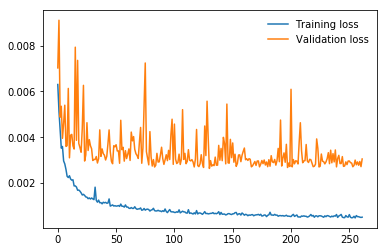

In [20]:
plt.plot(train_losses, label='Training loss')
plt.plot(eval_losses, label='Validation loss')
plt.legend(frameon=False)


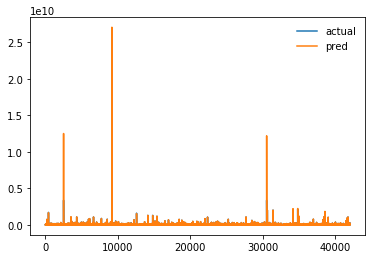

In [21]:
model.eval()
label = y_train.cpu()
label = y_scaler.inverse_transform(label)
with torch.no_grad():
    pred = model(X_train)
    pred = pred.cpu().numpy()
    pred = y_scaler.inverse_transform(pred)
    plot(label, pred)

## Submission 

In [22]:
pred = test_func(model, X_test)


In [23]:
submission = pd.read_csv('./dataset-0510/submit_test.csv')
submission['total_price'] = pred
submission.to_csv('submission/DNN2_result.csv', index=False)
submission

,building_id,total_price
0,X5gsdTWGS3W7JJQB,2.286014e+07
1,BTshNOJyKHnT2YIT,3.642489e+06
2,dhdymr0lV8N5kZOT,6.554556e+06
3,VEwyGGMcD56w5BOc,5.936388e+06
4,wmUeMoJZfsqaSX9b,6.020499e+05
5,EtBjGAHmHCe9t7TZ,1.702739e+06
6,hPNH34vmaZtvBtqc,1.179264e+07
7,wXjeI38bYDMJJwZC,1.088169e+07
8,fxZSGX6aPAFKU8W4,6.164922e+06
9,ewr0Fx6ign87OwaV,1.945114e+06


### test result

Batch size use 128 or 32 , learning rate use 0.003 which find loss will stock in 0.6

Result 1 DNN 233->256->128->1, lr=0.001, batch_size=128, predict score : 13
change: 
- replacing Standard to MinMax 
- adding DropOut 0.3 layer
- batch size change to 512

Result 2 lr=0.001, batch_size=64, DNN 233->256->128->64->1
after 1k loss : 0.00011785521522113447, can't decrease...
- x_scale false
- y_scale true

Result 3 lr=0.001 batch_size=128 DNN 211->256->512->512->256->128->1
after 1w loss : 0.0003, test loss : 0.0007 score: 1670

Result 4 lr=0.001 batch_size=128 DNN 211->256->512->512->256->128->64->32->1
train_loss: 0.0004, test loss: 0.0002 score: 1600

Result 5 lr=0.001 batch_size=128 DNN 211->256->512->512->256->128->64->32->1 + batch_noram
train_loss: 0.0005, test loss: 0.003 score: 1600


### question

why output is negative?